# Work
請結合前面的知識與程式碼，比較不同的 regularization 的組合對訓練的結果與影響：如 dropout, regularizers, batch-normalization 等

Ans: 若比較模型準確率, batch-normalization > regularizers > dropout

In [27]:
import os
import keras
import itertools
# Disable GPU
os.environ["CUDA_VISIBLE_DEVICES"] = ""

In [28]:
train, test = keras.datasets.cifar10.load_data()

In [29]:
## 資料前處理
def preproc_x(x, flatten=True):
    x = x / 255.
    if flatten:
        x = x.reshape((len(x), -1))
    return x

def preproc_y(y, num_classes=10):
    if y.shape[-1] == 1:
        y = keras.utils.to_categorical(y, num_classes)
    return y    

In [30]:
x_train, y_train = train
x_test, y_test = test

# Preproc the inputs
x_train = preproc_x(x_train)
x_test = preproc_x(x_test)

# Preprc the outputs
y_train = preproc_y(y_train)
y_test = preproc_y(y_test)

In [31]:
#regularization

In [32]:
from keras.regularizers import l1_l2

"""
建立神經網路
"""
def build_mlp(input_shape, output_units=10, num_neurons=[512, 256, 128], l1_ratio=0.0, l2_ratio=0.0):
    input_layer = keras.layers.Input(input_shape)
    
    for i, n_units in enumerate(num_neurons):
        if i == 0:
            x = keras.layers.Dense(units=n_units, 
                                   activation="relu", 
                                   name="hidden_layer"+str(i+1), 
                                   kernel_regularizer=l1_l2(l1=l1_ratio, l2=l2_ratio))(input_layer)
        else:
            x = keras.layers.Dense(units=n_units, 
                                   activation="relu", 
                                   name="hidden_layer"+str(i+1),
                                   kernel_regularizer=l1_l2(l1=l1_ratio, l2=l2_ratio))(x)
    
    out = keras.layers.Dense(units=output_units, activation="softmax", name="output")(x)
    
    model = keras.models.Model(inputs=[input_layer], outputs=[out])
    return model

In [33]:
## 超參數設定
LEARNING_RATE = 1e-3
EPOCHS = 50
BATCH_SIZE = 256
MOMENTUM = 0.95
L1_EXP = [1e-2, 1e-4, 1e-8, 1e-12, 0.0]
L2_EXP = [1e-2, 1e-4, 1e-8, 1e-12, 0.0]

In [34]:
results = {}
for l1r, l2r in itertools.product(L1_EXP, L2_EXP):
    keras.backend.clear_session() # 把舊的 Graph 清掉
    print("Experiment with L1 = %.6f, L2 = %.6f" % (l1r, l2r))
    model = build_mlp(input_shape=x_train.shape[1:], l1_ratio=l1r, l2_ratio=l2r)
    model.summary()
    optimizer = keras.optimizers.SGD(lr=LEARNING_RATE, nesterov=True, momentum=MOMENTUM)
    model.compile(loss="categorical_crossentropy", metrics=["accuracy"], optimizer=optimizer)

    model.fit(x_train, y_train, 
              epochs=EPOCHS, 
              batch_size=BATCH_SIZE, 
              validation_data=(x_test, y_test), 
              shuffle=True)
    
    # Collect results
    train_loss = model.history.history["loss"]
    valid_loss = model.history.history["val_loss"]
    train_acc = model.history.history["accuracy"]
    valid_acc = model.history.history["val_accuracy"]
    
    exp_name_tag = "exp-l1-%s-l2-%s" % (str(l1r), str(l2r))
    results[exp_name_tag] = {'train-loss': train_loss,
                             'valid-loss': valid_loss,
                             'train-acc': train_acc,
                             'valid-acc': valid_acc}

Experiment with L1 = 0.010000, L2 = 0.010000
Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 3072)              0         
_________________________________________________________________
hidden_layer1 (Dense)        (None, 512)               1573376   
_________________________________________________________________
hidden_layer2 (Dense)        (None, 256)               131328    
_________________________________________________________________
hidden_layer3 (Dense)        (None, 128)               32896     
_________________________________________________________________
output (Dense)               (None, 10)                1290      
Total params: 1,738,890
Trainable params: 1,738,890
Non-trainable params: 0
_________________________________________________________________
Train on 50000 samples, validate on 10000 samples
Epoch 1/50
50000/500

50000/50000 [==============================] - 10s 197us/step - loss: 2.4614 - accuracy: 0.0975 - val_loss: 2.4615 - val_accuracy: 0.1000
Epoch 49/50
50000/50000 [==============================] - 10s 198us/step - loss: 2.4614 - accuracy: 0.0988 - val_loss: 2.4614 - val_accuracy: 0.1000
Epoch 50/50
50000/50000 [==============================] - 10s 197us/step - loss: 2.4614 - accuracy: 0.0973 - val_loss: 2.4614 - val_accuracy: 0.1000
Experiment with L1 = 0.010000, L2 = 0.000100
Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 3072)              0         
_________________________________________________________________
hidden_layer1 (Dense)        (None, 512)               1573376   
_________________________________________________________________
hidden_layer2 (Dense)        (None, 256)               131328    
______________________________________

50000/50000 [==============================] - 10s 196us/step - loss: 2.4626 - accuracy: 0.0972 - val_loss: 2.4625 - val_accuracy: 0.1000
Epoch 46/50
50000/50000 [==============================] - 10s 207us/step - loss: 2.4626 - accuracy: 0.0979 - val_loss: 2.4627 - val_accuracy: 0.1000
Epoch 47/50
50000/50000 [==============================] - 12s 238us/step - loss: 2.4626 - accuracy: 0.0972 - val_loss: 2.4625 - val_accuracy: 0.1000
Epoch 48/50
50000/50000 [==============================] - 10s 200us/step - loss: 2.4626 - accuracy: 0.0975 - val_loss: 2.4627 - val_accuracy: 0.1000
Epoch 49/50
50000/50000 [==============================] - 12s 244us/step - loss: 2.4626 - accuracy: 0.0971 - val_loss: 2.4626 - val_accuracy: 0.1000
Epoch 50/50
50000/50000 [==============================] - 13s 251us/step - loss: 2.4626 - accuracy: 0.0978 - val_loss: 2.4627 - val_accuracy: 0.1000
Experiment with L1 = 0.010000, L2 = 0.000000
Model: "model_1"
__________________________________________________

50000/50000 [==============================] - 7s 138us/step - loss: 2.4626 - accuracy: 0.0966 - val_loss: 2.4625 - val_accuracy: 0.1000
Epoch 43/50
50000/50000 [==============================] - 6s 122us/step - loss: 2.4626 - accuracy: 0.0990 - val_loss: 2.4627 - val_accuracy: 0.1000
Epoch 44/50
50000/50000 [==============================] - 7s 141us/step - loss: 2.4626 - accuracy: 0.0969 - val_loss: 2.4626 - val_accuracy: 0.1000
Epoch 45/50
50000/50000 [==============================] - 7s 135us/step - loss: 2.4626 - accuracy: 0.0979 - val_loss: 2.4625 - val_accuracy: 0.1000
Epoch 46/50
50000/50000 [==============================] - 8s 159us/step - loss: 2.4626 - accuracy: 0.0976 - val_loss: 2.4625 - val_accuracy: 0.1000
Epoch 47/50
50000/50000 [==============================] - 7s 136us/step - loss: 2.4626 - accuracy: 0.0988 - val_loss: 2.4625 - val_accuracy: 0.1000
Epoch 48/50
50000/50000 [==============================] - 7s 139us/step - loss: 2.4626 - accuracy: 0.0998 - val_loss:

50000/50000 [==============================] - 7s 146us/step - loss: 2.4626 - accuracy: 0.0980 - val_loss: 2.4623 - val_accuracy: 0.1000
Epoch 40/50
50000/50000 [==============================] - 6s 123us/step - loss: 2.4626 - accuracy: 0.0981 - val_loss: 2.4623 - val_accuracy: 0.1000
Epoch 41/50
50000/50000 [==============================] - 8s 155us/step - loss: 2.4626 - accuracy: 0.0986 - val_loss: 2.4625 - val_accuracy: 0.1000
Epoch 42/50
50000/50000 [==============================] - 8s 151us/step - loss: 2.4626 - accuracy: 0.0991 - val_loss: 2.4624 - val_accuracy: 0.1000
Epoch 43/50
50000/50000 [==============================] - 7s 132us/step - loss: 2.4626 - accuracy: 0.0999 - val_loss: 2.4625 - val_accuracy: 0.1000
Epoch 44/50
50000/50000 [==============================] - 7s 133us/step - loss: 2.4626 - accuracy: 0.0992 - val_loss: 2.4625 - val_accuracy: 0.1000
Epoch 45/50
50000/50000 [==============================] - 7s 137us/step - loss: 2.4626 - accuracy: 0.0989 - val_loss:

50000/50000 [==============================] - 16s 311us/step - loss: 2.4626 - accuracy: 0.0979 - val_loss: 2.4627 - val_accuracy: 0.1000
Epoch 37/50
50000/50000 [==============================] - 12s 245us/step - loss: 2.4626 - accuracy: 0.0975 - val_loss: 2.4625 - val_accuracy: 0.1000
Epoch 38/50
50000/50000 [==============================] - 11s 228us/step - loss: 2.4626 - accuracy: 0.0972 - val_loss: 2.4626 - val_accuracy: 0.1000
Epoch 39/50
50000/50000 [==============================] - 11s 223us/step - loss: 2.4626 - accuracy: 0.0973 - val_loss: 2.4626 - val_accuracy: 0.1000
Epoch 40/50
50000/50000 [==============================] - 9s 186us/step - loss: 2.4626 - accuracy: 0.0974 - val_loss: 2.4626 - val_accuracy: 0.1000
Epoch 41/50
50000/50000 [==============================] - 10s 191us/step - loss: 2.4626 - accuracy: 0.0996 - val_loss: 2.4626 - val_accuracy: 0.1000
Epoch 42/50
50000/50000 [==============================] - 15s 307us/step - loss: 2.4626 - accuracy: 0.0964 - val

50000/50000 [==============================] - 6s 123us/step - loss: 1.8465 - accuracy: 0.4633 - val_loss: 1.8648 - val_accuracy: 0.4560
Epoch 34/50
50000/50000 [==============================] - 8s 158us/step - loss: 1.8364 - accuracy: 0.4619 - val_loss: 1.8424 - val_accuracy: 0.4595
Epoch 35/50
50000/50000 [==============================] - 7s 146us/step - loss: 1.8245 - accuracy: 0.4661 - val_loss: 1.8305 - val_accuracy: 0.4595
Epoch 36/50
50000/50000 [==============================] - 6s 122us/step - loss: 1.8167 - accuracy: 0.4660 - val_loss: 1.8545 - val_accuracy: 0.4422
Epoch 37/50
50000/50000 [==============================] - 6s 122us/step - loss: 1.8099 - accuracy: 0.4656 - val_loss: 1.8271 - val_accuracy: 0.4565
Epoch 38/50
50000/50000 [==============================] - 7s 130us/step - loss: 1.8006 - accuracy: 0.4693 - val_loss: 1.8402 - val_accuracy: 0.4475
Epoch 39/50
50000/50000 [==============================] - 6s 129us/step - loss: 1.7959 - accuracy: 0.4690 - val_loss:

50000/50000 [==============================] - 6s 122us/step - loss: 3.5411 - accuracy: 0.5837 - val_loss: 3.7181 - val_accuracy: 0.5071
Epoch 31/50
50000/50000 [==============================] - 6s 124us/step - loss: 3.4836 - accuracy: 0.5879 - val_loss: 3.6465 - val_accuracy: 0.5193
Epoch 32/50
50000/50000 [==============================] - 6s 130us/step - loss: 3.4249 - accuracy: 0.5919 - val_loss: 3.6288 - val_accuracy: 0.5126
Epoch 33/50
50000/50000 [==============================] - 6s 127us/step - loss: 3.3703 - accuracy: 0.5936 - val_loss: 3.5283 - val_accuracy: 0.5329
Epoch 34/50
50000/50000 [==============================] - 8s 156us/step - loss: 3.3181 - accuracy: 0.5976 - val_loss: 3.5108 - val_accuracy: 0.5191
Epoch 35/50
50000/50000 [==============================] - 8s 158us/step - loss: 3.2673 - accuracy: 0.6007 - val_loss: 3.4294 - val_accuracy: 0.5275
Epoch 36/50
50000/50000 [==============================] - 8s 159us/step - loss: 3.2122 - accuracy: 0.6044 - val_loss:

50000/50000 [==============================] - 10s 206us/step - loss: 3.7045 - accuracy: 0.5743 - val_loss: 3.8101 - val_accuracy: 0.5255
Epoch 28/50
50000/50000 [==============================] - 10s 204us/step - loss: 3.6501 - accuracy: 0.5774 - val_loss: 3.8160 - val_accuracy: 0.5061
Epoch 29/50
50000/50000 [==============================] - 11s 227us/step - loss: 3.5920 - accuracy: 0.5802 - val_loss: 3.7943 - val_accuracy: 0.5073
Epoch 30/50
50000/50000 [==============================] - 11s 221us/step - loss: 3.5368 - accuracy: 0.5842 - val_loss: 3.7128 - val_accuracy: 0.5049
Epoch 31/50
50000/50000 [==============================] - 10s 198us/step - loss: 3.4803 - accuracy: 0.5884 - val_loss: 3.6252 - val_accuracy: 0.5313
Epoch 32/50
50000/50000 [==============================] - 10s 199us/step - loss: 3.4284 - accuracy: 0.5900 - val_loss: 3.6935 - val_accuracy: 0.4977
Epoch 33/50
50000/50000 [==============================] - 11s 229us/step - loss: 3.3770 - accuracy: 0.5938 - va

50000/50000 [==============================] - 8s 154us/step - loss: 3.8991 - accuracy: 0.5572 - val_loss: 3.9773 - val_accuracy: 0.5167
Epoch 25/50
50000/50000 [==============================] - 7s 136us/step - loss: 3.8368 - accuracy: 0.5600 - val_loss: 3.9284 - val_accuracy: 0.5156
Epoch 26/50
50000/50000 [==============================] - 7s 142us/step - loss: 3.7762 - accuracy: 0.5660 - val_loss: 3.9111 - val_accuracy: 0.5148
Epoch 27/50
50000/50000 [==============================] - 8s 161us/step - loss: 3.7198 - accuracy: 0.5668 - val_loss: 3.8111 - val_accuracy: 0.5249
Epoch 28/50
50000/50000 [==============================] - 7s 142us/step - loss: 3.6593 - accuracy: 0.5726 - val_loss: 3.7750 - val_accuracy: 0.5113
Epoch 29/50
50000/50000 [==============================] - 6s 120us/step - loss: 3.6018 - accuracy: 0.5768 - val_loss: 3.7342 - val_accuracy: 0.5201
Epoch 30/50
50000/50000 [==============================] - 7s 133us/step - loss: 3.5465 - accuracy: 0.5800 - val_loss:

50000/50000 [==============================] - 6s 121us/step - loss: 4.0818 - accuracy: 0.5486 - val_loss: 4.1381 - val_accuracy: 0.5103
Epoch 22/50
50000/50000 [==============================] - 6s 120us/step - loss: 4.0177 - accuracy: 0.5533 - val_loss: 4.1010 - val_accuracy: 0.5116
Epoch 23/50
50000/50000 [==============================] - 6s 123us/step - loss: 3.9553 - accuracy: 0.5580 - val_loss: 4.0352 - val_accuracy: 0.5185
Epoch 24/50
50000/50000 [==============================] - 8s 155us/step - loss: 3.8906 - accuracy: 0.5626 - val_loss: 3.9957 - val_accuracy: 0.50660s - loss: 3.8929 - 
Epoch 25/50
50000/50000 [==============================] - 9s 186us/step - loss: 3.8307 - accuracy: 0.5674 - val_loss: 3.9255 - val_accuracy: 0.5197
Epoch 26/50
50000/50000 [==============================] - 8s 157us/step - loss: 3.7703 - accuracy: 0.5679 - val_loss: 3.8754 - val_accuracy: 0.5237
Epoch 27/50
50000/50000 [==============================] - 9s 184us/step - loss: 3.7105 - accuracy

50000/50000 [==============================] - 6s 121us/step - loss: 2.6106 - accuracy: 0.4663 - val_loss: 2.5577 - val_accuracy: 0.4549
Epoch 19/50
50000/50000 [==============================] - 8s 154us/step - loss: 2.4762 - accuracy: 0.4689 - val_loss: 2.4440 - val_accuracy: 0.4605
Epoch 20/50
50000/50000 [==============================] - 7s 148us/step - loss: 2.3592 - accuracy: 0.4717 - val_loss: 2.3216 - val_accuracy: 0.4635
Epoch 21/50
50000/50000 [==============================] - 8s 151us/step - loss: 2.2607 - accuracy: 0.4736 - val_loss: 2.2463 - val_accuracy: 0.4647
Epoch 22/50
50000/50000 [==============================] - 10s 196us/step - loss: 2.1749 - accuracy: 0.4757 - val_loss: 2.1656 - val_accuracy: 0.4655
Epoch 23/50
50000/50000 [==============================] - 9s 177us/step - loss: 2.1010 - accuracy: 0.4770 - val_loss: 2.1129 - val_accuracy: 0.4593
Epoch 24/50
50000/50000 [==============================] - 6s 124us/step - loss: 2.0373 - accuracy: 0.4815 - val_loss

50000/50000 [==============================] - 6s 130us/step - loss: 1.4880 - accuracy: 0.5277 - val_loss: 1.5628 - val_accuracy: 0.4933
Epoch 16/50
50000/50000 [==============================] - 6s 129us/step - loss: 1.4691 - accuracy: 0.5325 - val_loss: 1.6196 - val_accuracy: 0.4773
Epoch 17/50
50000/50000 [==============================] - 6s 127us/step - loss: 1.4510 - accuracy: 0.5399 - val_loss: 1.5734 - val_accuracy: 0.4878
Epoch 18/50
50000/50000 [==============================] - 6s 129us/step - loss: 1.4319 - accuracy: 0.5470 - val_loss: 1.5449 - val_accuracy: 0.5012
Epoch 19/50
50000/50000 [==============================] - 6s 130us/step - loss: 1.4154 - accuracy: 0.5514 - val_loss: 1.5596 - val_accuracy: 0.5039
Epoch 20/50
50000/50000 [==============================] - 6s 126us/step - loss: 1.3968 - accuracy: 0.5585 - val_loss: 1.5065 - val_accuracy: 0.5132
Epoch 21/50
50000/50000 [==============================] - 6s 127us/step - loss: 1.3811 - accuracy: 0.5626 - val_loss:

50000/50000 [==============================] - 7s 139us/step - loss: 1.4275 - accuracy: 0.4999 - val_loss: 1.4636 - val_accuracy: 0.4801
Epoch 13/50
50000/50000 [==============================] - 7s 133us/step - loss: 1.4065 - accuracy: 0.5078 - val_loss: 1.4549 - val_accuracy: 0.4863
Epoch 14/50
50000/50000 [==============================] - 7s 135us/step - loss: 1.3864 - accuracy: 0.5135 - val_loss: 1.4509 - val_accuracy: 0.4802
Epoch 15/50
50000/50000 [==============================] - 7s 132us/step - loss: 1.3643 - accuracy: 0.5198 - val_loss: 1.4327 - val_accuracy: 0.4936
Epoch 16/50
50000/50000 [==============================] - 7s 143us/step - loss: 1.3474 - accuracy: 0.5273 - val_loss: 1.4486 - val_accuracy: 0.4869
Epoch 17/50
50000/50000 [==============================] - 7s 131us/step - loss: 1.3291 - accuracy: 0.5323 - val_loss: 1.4224 - val_accuracy: 0.4939
Epoch 18/50
50000/50000 [==============================] - 7s 139us/step - loss: 1.3121 - accuracy: 0.5382 - val_loss:

50000/50000 [==============================] - 6s 123us/step - loss: 1.4874 - accuracy: 0.4778 - val_loss: 1.5160 - val_accuracy: 0.4629
Epoch 10/50
50000/50000 [==============================] - 6s 123us/step - loss: 1.4601 - accuracy: 0.4882 - val_loss: 1.4949 - val_accuracy: 0.4715
Epoch 11/50
50000/50000 [==============================] - 6s 123us/step - loss: 1.4348 - accuracy: 0.4985 - val_loss: 1.4841 - val_accuracy: 0.4721
Epoch 12/50
50000/50000 [==============================] - 6s 123us/step - loss: 1.4129 - accuracy: 0.5040 - val_loss: 1.4548 - val_accuracy: 0.4859
Epoch 13/50
50000/50000 [==============================] - 6s 122us/step - loss: 1.3903 - accuracy: 0.5143 - val_loss: 1.4429 - val_accuracy: 0.4894
Epoch 14/50
50000/50000 [==============================] - 6s 125us/step - loss: 1.3694 - accuracy: 0.5187 - val_loss: 1.4316 - val_accuracy: 0.4973
Epoch 15/50
50000/50000 [==============================] - 6s 125us/step - loss: 1.3490 - accuracy: 0.5264 - val_loss:

50000/50000 [==============================] - 8s 157us/step - loss: 1.5811 - accuracy: 0.4458 - val_loss: 1.5923 - val_accuracy: 0.4400
Epoch 7/50
50000/50000 [==============================] - 9s 189us/step - loss: 1.5449 - accuracy: 0.4578 - val_loss: 1.5486 - val_accuracy: 0.4554
Epoch 8/50
50000/50000 [==============================] - 6s 124us/step - loss: 1.5133 - accuracy: 0.4684 - val_loss: 1.5230 - val_accuracy: 0.4651
Epoch 9/50
50000/50000 [==============================] - 8s 154us/step - loss: 1.4844 - accuracy: 0.4795 - val_loss: 1.5018 - val_accuracy: 0.4711
Epoch 10/50
50000/50000 [==============================] - 7s 134us/step - loss: 1.4568 - accuracy: 0.4876 - val_loss: 1.4915 - val_accuracy: 0.4715
Epoch 11/50
50000/50000 [==============================] - 7s 146us/step - loss: 1.4311 - accuracy: 0.4978 - val_loss: 1.4771 - val_accuracy: 0.4779
Epoch 12/50
50000/50000 [==============================] - 6s 128us/step - loss: 1.4088 - accuracy: 0.5045 - val_loss: 1.

50000/50000 [==============================] - 10s 192us/step - loss: 11.3451 - accuracy: 0.3826 - val_loss: 10.5958 - val_accuracy: 0.3867
Epoch 4/50
50000/50000 [==============================] - 10s 192us/step - loss: 9.9329 - accuracy: 0.3987 - val_loss: 9.2934 - val_accuracy: 0.4072
Epoch 5/50
50000/50000 [==============================] - 10s 197us/step - loss: 8.7330 - accuracy: 0.4087 - val_loss: 8.1891 - val_accuracy: 0.4125
Epoch 6/50
50000/50000 [==============================] - 10s 193us/step - loss: 7.7090 - accuracy: 0.4168 - val_loss: 7.2488 - val_accuracy: 0.4272
Epoch 7/50
50000/50000 [==============================] - 10s 192us/step - loss: 6.8375 - accuracy: 0.4235 - val_loss: 6.4398 - val_accuracy: 0.4296
Epoch 8/50
50000/50000 [==============================] - 10s 195us/step - loss: 6.0927 - accuracy: 0.4297 - val_loss: 5.7573 - val_accuracy: 0.4356
Epoch 9/50
50000/50000 [==============================] - 10s 192us/step - loss: 5.4566 - accuracy: 0.4343 - val_lo

Train on 50000 samples, validate on 10000 samples
Epoch 1/50
50000/50000 [==============================] - 10s 204us/step - loss: 2.1943 - accuracy: 0.2537 - val_loss: 2.0227 - val_accuracy: 0.3429
Epoch 2/50
50000/50000 [==============================] - 10s 193us/step - loss: 1.9616 - accuracy: 0.3626 - val_loss: 1.9124 - val_accuracy: 0.3799
Epoch 3/50
50000/50000 [==============================] - 10s 191us/step - loss: 1.8779 - accuracy: 0.3899 - val_loss: 1.8438 - val_accuracy: 0.4066
Epoch 4/50
50000/50000 [==============================] - 10s 209us/step - loss: 1.8200 - accuracy: 0.4103 - val_loss: 1.7978 - val_accuracy: 0.4225
Epoch 5/50
50000/50000 [==============================] - 9s 177us/step - loss: 1.7711 - accuracy: 0.4253 - val_loss: 1.7584 - val_accuracy: 0.4313
Epoch 6/50
50000/50000 [==============================] - 10s 196us/step - loss: 1.7314 - accuracy: 0.4417 - val_loss: 1.7284 - val_accuracy: 0.4397
Epoch 7/50
50000/50000 [==============================] -

Train on 50000 samples, validate on 10000 samples
Epoch 1/50
50000/50000 [==============================] - 10s 209us/step - loss: 2.0189 - accuracy: 0.2828 - val_loss: 1.8483 - val_accuracy: 0.3556
Epoch 2/50
50000/50000 [==============================] - 10s 194us/step - loss: 1.7928 - accuracy: 0.3696 - val_loss: 1.7411 - val_accuracy: 0.3937
Epoch 3/50
50000/50000 [==============================] - 10s 192us/step - loss: 1.7117 - accuracy: 0.4028 - val_loss: 1.6872 - val_accuracy: 0.4098
Epoch 4/50
50000/50000 [==============================] - 9s 189us/step - loss: 1.6553 - accuracy: 0.4215 - val_loss: 1.6340 - val_accuracy: 0.4249
Epoch 5/50
50000/50000 [==============================] - 10s 194us/step - loss: 1.6115 - accuracy: 0.4378 - val_loss: 1.6055 - val_accuracy: 0.4355
Epoch 6/50
50000/50000 [==============================] - 9s 186us/step - loss: 1.5756 - accuracy: 0.4480 - val_loss: 1.5711 - val_accuracy: 0.4476
Epoch 7/50
50000/50000 [==============================] - 

Train on 50000 samples, validate on 10000 samples
Epoch 1/50
50000/50000 [==============================] - 12s 234us/step - loss: 2.0426 - accuracy: 0.2656 - val_loss: 1.8662 - val_accuracy: 0.3445
Epoch 2/50
50000/50000 [==============================] - 12s 237us/step - loss: 1.8093 - accuracy: 0.3679 - val_loss: 1.7613 - val_accuracy: 0.3818
Epoch 3/50
50000/50000 [==============================] - 13s 251us/step - loss: 1.7198 - accuracy: 0.3993 - val_loss: 1.6850 - val_accuracy: 0.4112
Epoch 4/50
50000/50000 [==============================] - 10s 194us/step - loss: 1.6568 - accuracy: 0.4223 - val_loss: 1.6408 - val_accuracy: 0.4222
Epoch 5/50
50000/50000 [==============================] - 10s 209us/step - loss: 1.6091 - accuracy: 0.4391 - val_loss: 1.5954 - val_accuracy: 0.4415
Epoch 6/50
50000/50000 [==============================] - 10s 210us/step - loss: 1.5710 - accuracy: 0.4522 - val_loss: 1.5660 - val_accuracy: 0.4456
Epoch 7/50
50000/50000 [==============================] 

Trainable params: 1,738,890
Non-trainable params: 0
_________________________________________________________________
Train on 50000 samples, validate on 10000 samples
Epoch 1/50
50000/50000 [==============================] - 16s 311us/step - loss: 2.0565 - accuracy: 0.2627 - val_loss: 1.8818 - val_accuracy: 0.3443
Epoch 2/50
50000/50000 [==============================] - 15s 297us/step - loss: 1.8230 - accuracy: 0.3595 - val_loss: 1.7742 - val_accuracy: 0.3762
Epoch 3/50
50000/50000 [==============================] - 14s 288us/step - loss: 1.7385 - accuracy: 0.3885 - val_loss: 1.7019 - val_accuracy: 0.4082
Epoch 4/50
50000/50000 [==============================] - 15s 300us/step - loss: 1.6777 - accuracy: 0.4102 - val_loss: 1.6515 - val_accuracy: 0.4262
Epoch 5/50
50000/50000 [==============================] - 16s 319us/step - loss: 1.6304 - accuracy: 0.4295 - val_loss: 1.6165 - val_accuracy: 0.4319
Epoch 6/50
50000/50000 [==============================] - 16s 316us/step - loss: 1.5913

Train on 50000 samples, validate on 10000 samples
Epoch 1/50
50000/50000 [==============================] - 14s 287us/step - loss: 15.0676 - accuracy: 0.2715 - val_loss: 13.9367 - val_accuracy: 0.3390
Epoch 2/50
50000/50000 [==============================] - 14s 282us/step - loss: 13.0054 - accuracy: 0.3534 - val_loss: 12.1236 - val_accuracy: 0.3652
Epoch 3/50
50000/50000 [==============================] - 14s 286us/step - loss: 11.3354 - accuracy: 0.3807 - val_loss: 10.5874 - val_accuracy: 0.3825
Epoch 4/50
50000/50000 [==============================] - 18s 358us/step - loss: 9.9245 - accuracy: 0.3931 - val_loss: 9.2871 - val_accuracy: 0.4013
Epoch 5/50
50000/50000 [==============================] - 16s 310us/step - loss: 8.7254 - accuracy: 0.4055 - val_loss: 8.1874 - val_accuracy: 0.4083
Epoch 6/50
50000/50000 [==============================] - 15s 292us/step - loss: 7.7028 - accuracy: 0.4149 - val_loss: 7.2433 - val_accuracy: 0.4104
Epoch 7/50
50000/50000 [==========================

Train on 50000 samples, validate on 10000 samples
Epoch 1/50
50000/50000 [==============================] - 10s 193us/step - loss: 2.1499 - accuracy: 0.2835 - val_loss: 2.0006 - val_accuracy: 0.3449
Epoch 2/50
50000/50000 [==============================] - 10s 191us/step - loss: 1.9357 - accuracy: 0.3706 - val_loss: 1.8954 - val_accuracy: 0.3754
Epoch 3/50
50000/50000 [==============================] - 10s 194us/step - loss: 1.8525 - accuracy: 0.4030 - val_loss: 1.8292 - val_accuracy: 0.4052
Epoch 4/50
50000/50000 [==============================] - 10s 190us/step - loss: 1.7928 - accuracy: 0.4219 - val_loss: 1.7760 - val_accuracy: 0.4271
Epoch 5/50
50000/50000 [==============================] - 10s 193us/step - loss: 1.7475 - accuracy: 0.4367 - val_loss: 1.7356 - val_accuracy: 0.4341
Epoch 6/50
50000/50000 [==============================] - 9s 189us/step - loss: 1.7086 - accuracy: 0.4510 - val_loss: 1.7152 - val_accuracy: 0.4449
Epoch 7/50
50000/50000 [==============================] -

Train on 50000 samples, validate on 10000 samples
Epoch 1/50
50000/50000 [==============================] - 11s 211us/step - loss: 2.0399 - accuracy: 0.2710 - val_loss: 1.8707 - val_accuracy: 0.3414
Epoch 2/50
50000/50000 [==============================] - 10s 196us/step - loss: 1.8202 - accuracy: 0.3615 - val_loss: 1.7735 - val_accuracy: 0.3773
Epoch 3/50
50000/50000 [==============================] - 10s 191us/step - loss: 1.7431 - accuracy: 0.3874 - val_loss: 1.7100 - val_accuracy: 0.4002
Epoch 4/50
50000/50000 [==============================] - 10s 192us/step - loss: 1.6866 - accuracy: 0.4068 - val_loss: 1.6603 - val_accuracy: 0.4143
Epoch 5/50
50000/50000 [==============================] - 10s 193us/step - loss: 1.6389 - accuracy: 0.4232 - val_loss: 1.6258 - val_accuracy: 0.4257
Epoch 6/50
50000/50000 [==============================] - 10s 192us/step - loss: 1.6017 - accuracy: 0.4353 - val_loss: 1.5932 - val_accuracy: 0.4369
Epoch 7/50
50000/50000 [==============================] 

Train on 50000 samples, validate on 10000 samples
Epoch 1/50
50000/50000 [==============================] - 10s 197us/step - loss: 1.9970 - accuracy: 0.2847 - val_loss: 1.8482 - val_accuracy: 0.3549
Epoch 2/50
50000/50000 [==============================] - 9s 189us/step - loss: 1.7922 - accuracy: 0.3708 - val_loss: 1.7412 - val_accuracy: 0.3987
Epoch 3/50
50000/50000 [==============================] - 9s 190us/step - loss: 1.7112 - accuracy: 0.4007 - val_loss: 1.6783 - val_accuracy: 0.4097
Epoch 4/50
50000/50000 [==============================] - 9s 189us/step - loss: 1.6554 - accuracy: 0.4183 - val_loss: 1.6319 - val_accuracy: 0.4268
Epoch 5/50
50000/50000 [==============================] - 8s 152us/step - loss: 1.6109 - accuracy: 0.4348 - val_loss: 1.5912 - val_accuracy: 0.4462
Epoch 6/50
50000/50000 [==============================] - 9s 190us/step - loss: 1.5696 - accuracy: 0.4512 - val_loss: 1.5642 - val_accuracy: 0.4471
Epoch 7/50
50000/50000 [==============================] - 10s

Train on 50000 samples, validate on 10000 samples
Epoch 1/50
50000/50000 [==============================] - 9s 190us/step - loss: 2.0717 - accuracy: 0.2523 - val_loss: 1.8943 - val_accuracy: 0.3332
Epoch 2/50
50000/50000 [==============================] - 8s 160us/step - loss: 1.8332 - accuracy: 0.3535 - val_loss: 1.7773 - val_accuracy: 0.3753
Epoch 3/50
50000/50000 [==============================] - 10s 209us/step - loss: 1.7430 - accuracy: 0.3895 - val_loss: 1.7090 - val_accuracy: 0.3986
Epoch 4/50
50000/50000 [==============================] - 9s 184us/step - loss: 1.6809 - accuracy: 0.4096 - val_loss: 1.6542 - val_accuracy: 0.4152
Epoch 5/50
50000/50000 [==============================] - 9s 182us/step - loss: 1.6315 - accuracy: 0.4277 - val_loss: 1.6084 - val_accuracy: 0.4369
Epoch 6/50
50000/50000 [==============================] - 9s 189us/step - loss: 1.5917 - accuracy: 0.4420 - val_loss: 1.5784 - val_accuracy: 0.4427
Epoch 7/50
50000/50000 [==============================] - 9s 

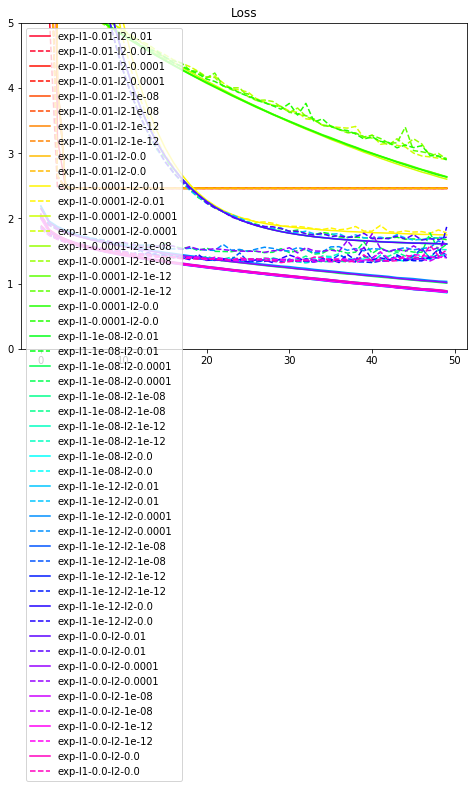

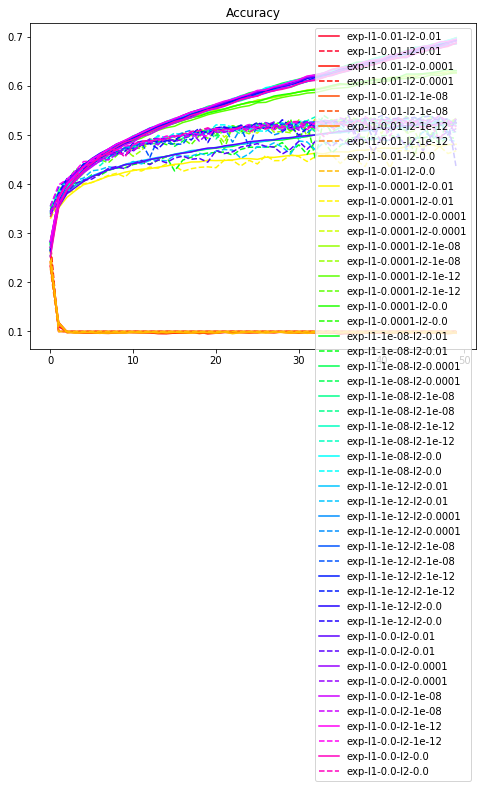

In [35]:
import matplotlib.pyplot as plt
%matplotlib inline

import matplotlib.cm as mplcm
import matplotlib.colors as colors
NUM_COLORS = 25

cm = plt.get_cmap('gist_rainbow')
cNorm  = colors.Normalize(vmin=0, vmax=NUM_COLORS-1)
scalarMap = mplcm.ScalarMappable(norm=cNorm, cmap=cm)
color_bar = [scalarMap.to_rgba(i) for i in range(NUM_COLORS)]

plt.figure(figsize=(8,6))
for i, cond in enumerate(results.keys()):
    plt.plot(range(len(results[cond]['train-loss'])),results[cond]['train-loss'], '-', label=cond, color=color_bar[i])
    plt.plot(range(len(results[cond]['valid-loss'])),results[cond]['valid-loss'], '--', label=cond, color=color_bar[i])
plt.title("Loss")
plt.ylim([0, 5])
plt.legend()
plt.show()

plt.figure(figsize=(8,6))
for i, cond in enumerate(results.keys()):
    plt.plot(range(len(results[cond]['train-acc'])),results[cond]['train-acc'], '-', label=cond, color=color_bar[i])
    plt.plot(range(len(results[cond]['valid-acc'])),results[cond]['valid-acc'], '--', label=cond, color=color_bar[i])
plt.title("Accuracy")
plt.legend()
plt.show()

In [36]:
#dropout

In [37]:
from keras.layers import Dropout
def build_mlp(input_shape, output_units=10, num_neurons=[512, 256, 128], drp_ratio=0.2):
    input_layer = keras.layers.Input(input_shape)
    
    for i, n_units in enumerate(num_neurons):
        if i == 0:
            x = keras.layers.Dense(units=n_units, 
                                   activation="relu", 
                                   name="hidden_layer"+str(i+1))(input_layer)
            x = Dropout(drp_ratio)(x)
        else:
            x = keras.layers.Dense(units=n_units, 
                                   activation="relu", 
                                   name="hidden_layer"+str(i+1))(x)
            x = Dropout(drp_ratio)(x)
    
    out = keras.layers.Dense(units=output_units, activation="softmax", name="output")(x)
    
    model = keras.models.Model(inputs=[input_layer], outputs=[out])
    return model

In [38]:
## 超參數設定
LEARNING_RATE = 1e-4
EPOCHS = 50
BATCH_SIZE = 256
MOMENTUM = 0.95

"""
建立實驗組合
"""
Dropout_EXP = [0.1, 0.2, 0.4]
LAYER_NEURONS = [[128, 128, 128], [128, 256, 256], [128, 256, 512]]

In [39]:
results = {}
"""
以迴圈方式遍歷組合來訓練模型
"""
for i, (layer_neurons, drp_rate) in enumerate(itertools.product(LAYER_NEURONS, Dropout_EXP)):
    print("Numbers of exp: %i, layer: %s, dropout_rate: %.2f" % (i, layer_neurons, drp_rate))
    model = build_mlp(input_shape=x_train.shape[1:], num_neurons=layer_neurons, drp_ratio=drp_rate)
    model.summary()
    optimizer = keras.optimizers.Adam(lr=LEARNING_RATE)
    model.compile(loss="categorical_crossentropy", metrics=["accuracy"], optimizer=optimizer)

    model.fit(x_train, y_train, 
              epochs=EPOCHS, 
              batch_size=BATCH_SIZE, 
              validation_data=(x_test, y_test), 
              verbose=0,
              shuffle=True)

    # Collect results
    exp_name_tag = ("exp-%s" % (i))
    results[exp_name_tag] = {'train-loss': model.history.history["loss"],
                             'valid-loss': model.history.history["val_loss"],
                             'train-acc': model.history.history["accuracy"],
                             'valid-acc': model.history.history["val_accuracy"]}

Numbers of exp: 0, layer: [128, 128, 128], dropout_rate: 0.10
Model: "model_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (None, 3072)              0         
_________________________________________________________________
hidden_layer1 (Dense)        (None, 128)               393344    
_________________________________________________________________
dropout_1 (Dropout)          (None, 128)               0         
_________________________________________________________________
hidden_layer2 (Dense)        (None, 128)               16512     
_________________________________________________________________
dropout_2 (Dropout)          (None, 128)               0         
_________________________________________________________________
hidden_layer3 (Dense)        (None, 128)               16512     
_______________________________________________________________

Numbers of exp: 6, layer: [128, 256, 512], dropout_rate: 0.10
Model: "model_8"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_8 (InputLayer)         (None, 3072)              0         
_________________________________________________________________
hidden_layer1 (Dense)        (None, 128)               393344    
_________________________________________________________________
dropout_19 (Dropout)         (None, 128)               0         
_________________________________________________________________
hidden_layer2 (Dense)        (None, 256)               33024     
_________________________________________________________________
dropout_20 (Dropout)         (None, 256)               0         
_________________________________________________________________
hidden_layer3 (Dense)        (None, 512)               131584    
_______________________________________________________________

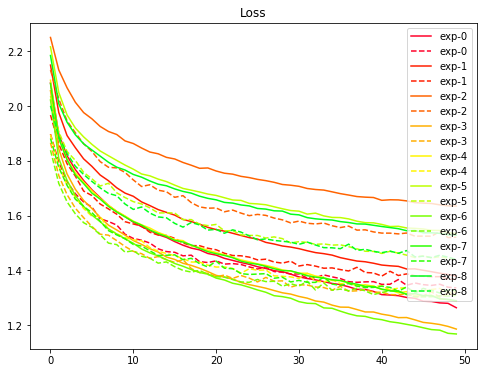

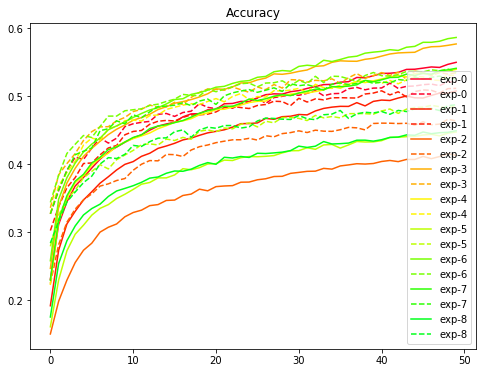

In [40]:
import matplotlib.pyplot as plt
import matplotlib.cm as mplcm
import matplotlib.colors as colors
%matplotlib inline
NUM_COLORS = 20

cm = plt.get_cmap('gist_rainbow')
cNorm  = colors.Normalize(vmin=0, vmax=NUM_COLORS-1)
scalarMap = mplcm.ScalarMappable(norm=cNorm, cmap=cm)
color_bar = [scalarMap.to_rgba(i) for i in range(NUM_COLORS)]

plt.figure(figsize=(8,6))
for i, cond in enumerate(results.keys()):
    plt.plot(range(len(results[cond]['train-loss'])),results[cond]['train-loss'], '-', label=cond, color=color_bar[i])
    plt.plot(range(len(results[cond]['valid-loss'])),results[cond]['valid-loss'], '--', label=cond, color=color_bar[i])
plt.title("Loss")
plt.legend()
plt.show()

plt.figure(figsize=(8,6))
for i, cond in enumerate(results.keys()):
    plt.plot(range(len(results[cond]['train-acc'])),results[cond]['train-acc'], '-', label=cond, color=color_bar[i])
    plt.plot(range(len(results[cond]['valid-acc'])),results[cond]['valid-acc'], '--', label=cond, color=color_bar[i])
plt.title("Accuracy")
plt.legend()
plt.show()

In [41]:
#batch-normalization

In [42]:
from keras.layers import BatchNormalization, Activation
def build_mlp(input_shape, output_units=10, num_neurons=[512, 256, 128], pre_activate=False):
    input_layer = keras.layers.Input(input_shape)
    
    for i, n_units in enumerate(num_neurons):
        if i == 0:
            x = keras.layers.Dense(units=n_units, 
                                   name="hidden_layer"+str(i+1))(input_layer)
            if pre_activate:
                x = BatchNormalization()(x)
                x = Activation("relu")(x)
            else:
                x = Activation("relu")(x)
                x = BatchNormalization()(x)
        else:
            x = keras.layers.Dense(units=n_units, 
                                   name="hidden_layer"+str(i+1))(x)
            if pre_activate:
                x = BatchNormalization()(x)
                x = Activation("relu")(x)
            else:
                x = Activation("relu")(x)
                x = BatchNormalization()(x)
                
    
    out = keras.layers.Dense(units=output_units, activation="softmax", name="output")(x)
    
    model = keras.models.Model(inputs=[input_layer], outputs=[out])
    return model

In [43]:
## 超參數設定
LEARNING_RATE = 1e-3
EPOCHS = 50
BATCH_SIZE = [2, 16, 32, 128]
PRE_ACTIVATE = [True, False]
MOMENTUM = 0.95

In [44]:

results = {}
for i, (use_preact, bz) in enumerate(itertools.product(PRE_ACTIVATE, BATCH_SIZE)):
    print("Numbers of exp: %i, use_preact: %s, batch_size: %i" % (i, use_preact, bz))
    model = build_mlp(input_shape=x_train.shape[1:], pre_activate=use_preact)
    model.summary()
    optimizer = keras.optimizers.Adam(lr=LEARNING_RATE)
    model.compile(loss="categorical_crossentropy", metrics=["accuracy"], optimizer=optimizer)

    model.fit(x_train, y_train, 
              epochs=EPOCHS, 
              batch_size=bz, 
              validation_data=(x_test, y_test), 
              verbose=0,
              shuffle=True)
    
    # Collect results
    exp_name_tag = ("exp-%s" % (i))
    results[exp_name_tag] = {'train-loss': model.history.history["loss"],
                             'valid-loss': model.history.history["val_loss"],
                             'train-acc': model.history.history["accuracy"],
                             'valid-acc': model.history.history["val_accuracy"]}

Numbers of exp: 0, use_preact: True, batch_size: 2
Model: "model_11"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_11 (InputLayer)        (None, 3072)              0         
_________________________________________________________________
hidden_layer1 (Dense)        (None, 512)               1573376   
_________________________________________________________________
batch_normalization_1 (Batch (None, 512)               2048      
_________________________________________________________________
activation_1 (Activation)    (None, 512)               0         
_________________________________________________________________
hidden_layer2 (Dense)        (None, 256)               131328    
_________________________________________________________________
batch_normalization_2 (Batch (None, 256)               1024      
_________________________________________________________________
activat

Numbers of exp: 5, use_preact: False, batch_size: 16
Model: "model_16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_16 (InputLayer)        (None, 3072)              0         
_________________________________________________________________
hidden_layer1 (Dense)        (None, 512)               1573376   
_________________________________________________________________
activation_16 (Activation)   (None, 512)               0         
_________________________________________________________________
batch_normalization_16 (Batc (None, 512)               2048      
_________________________________________________________________
hidden_layer2 (Dense)        (None, 256)               131328    
_________________________________________________________________
activation_17 (Activation)   (None, 256)               0         
_________________________________________________________________
batch

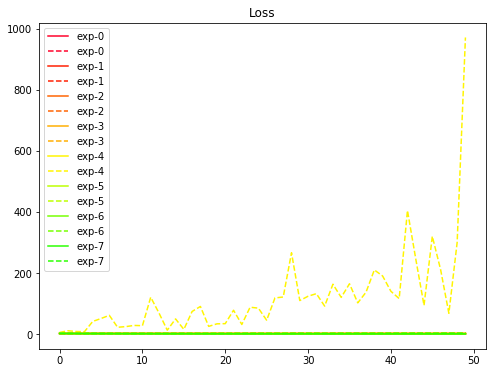

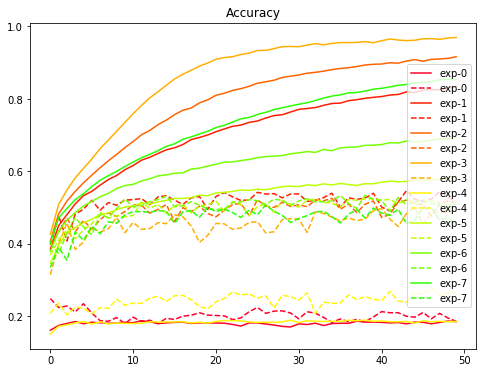

In [45]:
import matplotlib.pyplot as plt
import matplotlib.cm as mplcm
import matplotlib.colors as colors
%matplotlib inline
NUM_COLORS = 20

cm = plt.get_cmap('gist_rainbow')
cNorm  = colors.Normalize(vmin=0, vmax=NUM_COLORS-1)
scalarMap = mplcm.ScalarMappable(norm=cNorm, cmap=cm)
color_bar = [scalarMap.to_rgba(i) for i in range(NUM_COLORS)]

plt.figure(figsize=(8,6))
for i, cond in enumerate(results.keys()):
    plt.plot(range(len(results[cond]['train-loss'])),results[cond]['train-loss'], '-', label=cond, color=color_bar[i])
    plt.plot(range(len(results[cond]['valid-loss'])),results[cond]['valid-loss'], '--', label=cond, color=color_bar[i])
plt.title("Loss")
plt.legend()
plt.show()

plt.figure(figsize=(8,6))
for i, cond in enumerate(results.keys()):
    plt.plot(range(len(results[cond]['train-acc'])),results[cond]['train-acc'], '-', label=cond, color=color_bar[i])
    plt.plot(range(len(results[cond]['valid-acc'])),results[cond]['valid-acc'], '--', label=cond, color=color_bar[i])
plt.title("Accuracy")
plt.legend()
plt.show()